# Steam Game Sentiment Analysis

**Objective:**

This project aims to analyze the sentiment of customer reviews for a specific game on Steam using Python. By leveraging natural language processing (NLP) techniques, the project will extract valuable insights into player opinions, identify common themes, and assess the overall sentiment towards the game.

**Methodology:**

- Data Collection: **Web scraping** was employed to collect a dataset of 9,878 reviews from Steam, encompassing various aspects such as the review text, recommendation status, review length, playtime, posting date, and the number of users who found the review helpful. The web scraping was done using Selenium

- Data Cleaning and Preprocessing: The collected data underwent rigorous cleaning and preprocessing to ensure its quality and suitability for analysis. This included tasks such as:
 - Removing stop words, punctuation, and special characters
 - Handling inconsistencies in data formats
 - Addressing missing values
 - Tokenization and stemming/lemmatization

- **Natural Language Processing (NLP)**: NLP techniques were applied to extract meaningful information from the review text.

- **Sentiment Analysis**: Quantifying the sentiment polarity of reviews using sentiment analysis techniques.

- Exploratory Data Analysis and Visualization: The cleaned and processed data was analyzed to extract insights into customer opinions, review trends, and correlations between different variables. Visualizations were created using libraries like Matplotlib, Seaborn and Plotly to present the findings effectively.

**Expected Outcomes:**

- Identification of the overall sentiment towards the game (positive, negative, or neutral).
- Analysis of sentiment trends over time.
- Identification of key themes and topics discussed in the reviews.
- Correlation analysis between review length, playtime, and sentiment.
- Insights into factors influencing customer recommendations.


**Potential Applications:**

- Product Improvement: Understanding customer feedback can help game developers identify areas for improvement and enhance the gaming experience.
- Marketing and Promotion: Insights from sentiment analysis can inform marketing strategies and promotional efforts.
- Community Management: Monitoring sentiment can help game developers engage with the community and address concerns.
- Competitive Analysis: Comparing sentiment analysis results for different games can provide valuable insights into market trends and preferences

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import re
import time
from datetime import datetime
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from datetime import datetime
from wordcloud import WordCloud

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

## Web Scraping

In [89]:
game_id = 1968340
url_template = "https://steamcommunity.com/app/{}/reviews/?browsefilter=toprated&snr=1_5_100010_"
url = url_template.format(game_id)

print(url)

https://steamcommunity.com/app/1968340/reviews/?browsefilter=toprated&snr=1_5_100010_


In [90]:
s = Service(executable_path=r"C:\Users\98686\OneDrive\Desktop\chromedriver.exe")
driver = webdriver.Chrome(service=s)
driver.maximize_window()
driver.set_page_load_timeout(10)
driver.get(url)

In [91]:
def get_current_scroll_position(driver):
    return driver.execute_script("return window.pageYOffset;")

def scroll_to_bottom(driver):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)

def get_user_id(card):
    user_url = card.find_element(By.XPATH, './/div[@class="apphub_friend_block"]/div/a[2]').get_attribute('href')## href means url
    user_id = user_url.split('/')[-2]
    return user_id

def scrape_review_data(card):
    ## to get date
    date_element = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]/div[@class="date_posted"]')
    date = date_element.text.strip()
    ## to get early access element text
    early_access_review_element = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]/div[@class="early_access_review"]')
    early_access_review = early_access_review_element.text.strip()
    ## to get review content
    card_text_content_element = card.find_element(By.CLASS_NAME, 'apphub_CardTextContent')
    review_content = card_text_content_element.text.strip()
    excluded_elements = [date, early_access_review]
    ## to remove the content of other elements
    for excluded_element in excluded_elements:
        review_content = review_content.replace(excluded_element, "")
    review_content = review_content.replace("\n", "")
    ## to get length of review text
    review_length = len(review_content.replace(" ","")) ## compute length of review, excluding spaces
    ## to get text 'Recommended' or 'Not Recommended'
    thumb_text = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[2]').text.strip()
    ## to get no. of hours on record(i.e, playing hours)
    playing_hours = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[3]').text.strip()
    ## no. of people who found the reivew helpful
    number_of_found_helpful = card.find_element(By.XPATH, './/div[@class="found_helpful"]').text.strip()

    return early_access_review, review_content, thumb_text, review_length, playing_hours, date, number_of_found_helpful

In [92]:
reviews = []
profile_names_set = set() ## we've used set because it doesn't allow duplicates
max_scroll_attempts = 6

try:
    last_position = get_current_scroll_position(driver)
    running = True
    while running:
        cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')

        for card in cards:
            profile_name = get_user_id(card)
            if profile_name in profile_names_set:
                continue ## if a a steam_id has done a review already(as we have it in our steam_ids_set), then we'll skip those steam_ids' review to avoid duplicate data
            else:
                review = scrape_review_data(card)
                reviews.append(review)

        scroll_attempt = 0
        while scroll_attempt < max_scroll_attempts:
            scroll_to_bottom(driver)
            current_position = get_current_scroll_position(driver=driver)
            ## if the current_position==last_position, then increase the scroll attempt by 1 and wait 2 seconds
            if current_position == last_position:
                scroll_attempt += 1
                time.sleep(3)

                if current_position >= 3:
                    running = False
                    break
            else:
                last_position = current_position
                break
                

except Exception as e:
    print(e)

finally:
    driver.quit()

In [94]:
# Creating dataframe to store the scraped data
df = pd.DataFrame(reviews, columns=['EarlyAccess','ReviewText','Review','ReviewLength','PlayHours','DatePosted','Number_of_found_helpful'])
df.head(4)

,EarlyAccess,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Number_of_found_helpful
0,EARLY ACCESS REVIEW,You could definitely pass gameplay of this to ...,Recommended,80,1.4 hrs on record,"Posted: 28 September, 2022",269 people found this review helpful\n146 peop...
1,EARLY ACCESS REVIEW,Blowing up innocent civilians has never been t...,Recommended,52,2.8 hrs on record,"Posted: 4 November, 2022",87 people found this review helpful\n41 people...
2,EARLY ACCESS REVIEW,wait a minute thats not a terrorist thats a ch...,Recommended,54,5.2 hrs on record,"Posted: 11 September, 2022",93 people found this review helpful\n48 people...
3,EARLY ACCESS REVIEW,Because of the MW missions you play as a gunsh...,Recommended,113,2.7 hrs on record,"Posted: 7 October, 2022",28 people found this review helpful 0


In [104]:
df.to_csv('Steam_Reviews.csv')

In [97]:
df.shape

(9878, 7)

observation: There are total 9,878 reviews

## Data Cleaning

In [5]:
df = pd.read_csv('SteamReviews.csv')

In [6]:
df['EarlyAccess'].value_counts(), df.shape

(EarlyAccess
 EARLY ACCESS REVIEW    9878
 Name: count, dtype: int64,
 (9878, 8))

Observation: All the reivews are EarlyAccess, so we can drop the EarlyAccess column

In [7]:
df.drop(columns=['EarlyAccess'], axis=1, inplace=True)
df.head(1)

,Unnamed: 0,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Number_of_found_helpful
0,0,You could definitely pass gameplay of this to ...,Recommended,80,1.4 hrs on record,"Posted: 28 September, 2022",269 people found this review helpful\n146 peop...


In [8]:
# Cleaning PlayHours Column
df['PlayHours'] = df['PlayHours'].str.split().str[0]
df.head(1)

,Unnamed: 0,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Number_of_found_helpful
0,0,You could definitely pass gameplay of this to ...,Recommended,80,1.4,"Posted: 28 September, 2022",269 people found this review helpful\n146 peop...


In [9]:
# Cleaning Number_of_found_helpful
df['Number_of_found_helpful'] = df['Number_of_found_helpful'].str.split().str[0]
df.head(1)

,Unnamed: 0,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Number_of_found_helpful
0,0,You could definitely pass gameplay of this to ...,Recommended,80,1.4,"Posted: 28 September, 2022",269


In [10]:
# Cleaning DatePosted column and deriving Year, Month, Quarter, Weekday name columns from it
df['DatePosted'] = df['DatePosted'].str.replace('Posted: ','')
## Since the current year reviews have only values like 'January 26', whle others have '02 September, 2023'
def parse_date(date_str):
    if ',' in date_str:
        return pd.to_datetime(date_str, format='mixed')
    else:
        return pd.to_datetime(date_str + ' ' + str(pd.to_datetime('today').year), format='%B %d %Y')

df['DatePosted'] = df['DatePosted'].apply(parse_date)

df['Month'] = df['DatePosted'].dt.month_name()
df['Quarter'] = df['DatePosted'].dt.quarter
df['Day_name'] = df['DatePosted'].dt.day_name()
df['Year'] = df['DatePosted'].dt.year

df.head(2)


,Unnamed: 0,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Number_of_found_helpful,Month,Quarter,Day_name,Year
0,0,You could definitely pass gameplay of this to ...,Recommended,80,1.4,2022-09-28,269,September,3,Wednesday,2022
1,1,Blowing up innocent civilians has never been t...,Recommended,52,2.8,2022-11-04,87,November,4,Friday,2022


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9878 entries, 0 to 9877
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               9878 non-null   int64         
 1   ReviewText               9843 non-null   object        
 2   Review                   9878 non-null   object        
 3   ReviewLength             9878 non-null   int64         
 4   PlayHours                9878 non-null   object        
 5   DatePosted               9878 non-null   datetime64[ns]
 6   Number_of_found_helpful  9878 non-null   object        
 7   Month                    9878 non-null   object        
 8   Quarter                  9878 non-null   int32         
 9   Day_name                 9878 non-null   object        
 10  Year                     9878 non-null   int32         
dtypes: datetime64[ns](1), int32(2), int64(2), object(6)
memory usage: 771.8+ KB


Observation: PlayHours and Number_of_found_helpful columns' datatype is object, which should be numeric.

In [12]:
## Converting the PlayHours and Number_of_found_helpful columns data type to float and int, respectively

### The users which have zero playhours have 'No' as value, so we first replace 'No' values with 0
df['PlayHours'] = df['PlayHours'].map(lambda x: re.sub('No','0',x) if isinstance(x, str) else x).astype(float)
### The reviews which have zero Number_of_found_helpful have 'No' as value, so we first replace 'No' values with 0
df['Number_of_found_helpful'] = df['Number_of_found_helpful'].map(lambda x: re.sub('No','0', x) if isinstance(x, str) else x).astype(int)

df.head(1)

,Unnamed: 0,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Number_of_found_helpful,Month,Quarter,Day_name,Year
0,0,You could definitely pass gameplay of this to ...,Recommended,80,1.4,2022-09-28,269,September,3,Wednesday,2022


## EDA(Exploratory Data Analysis)

In [13]:
# Checking if the output variable is balanced or imbalanced? 
df['Review'].value_counts()

Review
Recommended        7705
Not Recommended    2173
Name: count, dtype: int64

**Q: How many Reviews are positive and how many are negative?**

In [35]:
fig = px.bar(df['Review'].value_counts(), title="No. of Positive and Negative Reviews")
fig.update_yaxes(title_text="Number of Reviews")
fig.update_xaxes(title_text="Review Type")
fig.update_layout(showlegend=False)
fig.show()

Observation: There are around 7.7k positve and 2.2k negative reviews. The number of positive reviews is more than thrice the number of neagtive reviews

**Q : Average Review Length for positive/negative reviews**

In [163]:
df_filtered = df.groupby('Review')['ReviewLength'].mean().reset_index()
fig = px.bar(data_frame=df_filtered, y='ReviewLength', x='Review', title='Average Review Length for Positive/Negative Reviews')
fig.update_xaxes(title_text="Review Type")
fig.update_yaxes(title_text="Average Review Length")
fig.show();

Observation: On an average, those users who gave postive reviews wrote longer reviews than the users who gave negative reviews

**Q: How many positive and negative reviews are marked as helpful?**

In [168]:
fig = px.bar(data_frame=df[df['Number_of_found_helpful']>=1]['Review'].value_counts(), title="Number of Reviews Marked Helpful, by Review Type")
fig.update_xaxes(title_text="Review Type")
fig.update_yaxes(title_text="Number of Reviews Marked Helpful")
fig.update_layout(showlegend= False)

Obervation: Positive Reviews are marked helpful more number of times than Negative Reviews

**Q: What is the Average Playing Hours for the players who left a review?**

In [186]:
print(f"Average Playing Hours of players who left a review: {df['PlayHours'].mean()} hours")

# Average Playing hours for players who left postive and for players who left negative reviews
df_filtered = df.groupby('Review')['PlayHours'].mean()
fig = px.bar(df_filtered, title="Average Playing Hours for players with positive and for players with negative reviews",
             width=900, height=400)
fig.update_yaxes(title_text="Average Playing Hours")
fig.update_layout(showlegend=False)
fig.show();

Average Playing Hours of players who left a review: 7.74116217857866 hours


Observation: Players who left a positive review have bit relatiely higher playing hours than those players who left a neagtive review

**Q: What is the trend of reviews over time? Also tell the trend of the postive and negative reviews seperately**

Text(0.5, 0, 'Date of Review Posted')

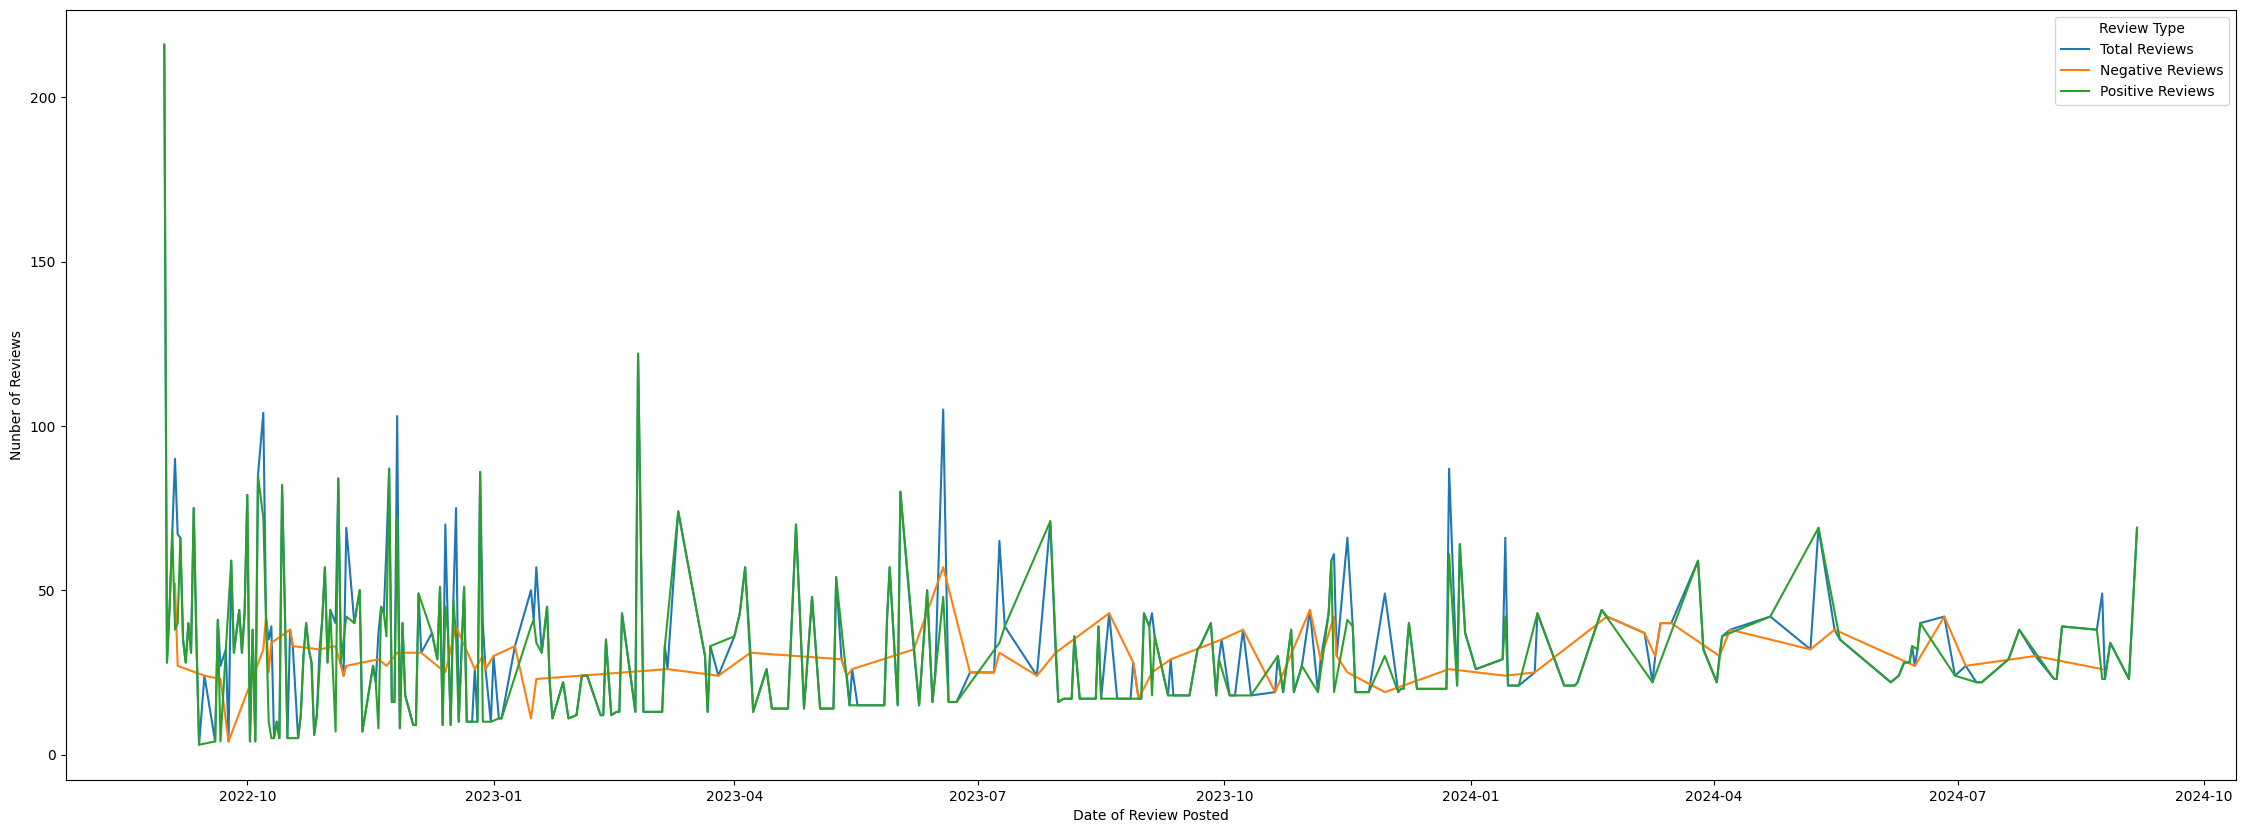

In [249]:
import seaborn as sns

df_filtered = df['DatePosted'].value_counts().reset_index()
df_positive = df[df['Review']=='Recommended']['DatePosted'].value_counts().reset_index()
df_negative = df[df['Review']=='Not Recommended']['DatePosted'].value_counts().reset_index()

plt.figure(figsize=(28,10))
sns.lineplot(df_filtered, x='DatePosted', y='count', label='Total Reviews')
sns.lineplot(df_negative, x='DatePosted', y='count', label='Negative Reviews')
sns.lineplot(df_positive, x='DatePosted', y='count', label='Positive Reviews')
plt.legend(title='Review Type')
plt.ylabel('Nunber of Reviews')
plt.xlabel('Date of Review Posted')

Observation: 
- The variance in number of positive reviews has reduced over time. On the other hand, the variance in the number of negative reviews has reamined somewhat similar overtime

**Q: What's the no. of reviews by quarters?**

In [268]:
fig = px.histogram(data_frame=df, x=df['Quarter'].astype(str), color=df['Review'].map({'Recommended':'Positive','Not Recommended':'Negative'}), 
                   title='Number of Reviews by Month')
fig.update_layout(yaxis_title="Number of Reviews", xaxis_title="Quarter", legend_title_text="Review Type")
fig.show()

Observation: 
- The 4th quarter has the highest number of reviews, followed by 3rd quarter. This could be due to that users played this game over in the months of 4th and 3rd quarter. 
- Also, we can notice that 2nd quarter has higher number of reviews than 1st quarter. So, we can say that as time passes in a year, the number of reviews increase(can be due to increase playing of the game). 
- In the 3rd and 4th quarter, as reviews increases, the number of negative reviews also increases. 

**Q: No. of Positive and Negative Reviews by Month**

In [269]:
fig = px.histogram(data_frame=df, x='Month', color=df['Review'].map({'Recommended':'Positive','Not Recommended':'Negative'}), title='Number of Reviews by Month')
fig.update_layout(yaxis_title="Number of Reviews", legend_title_text="Review Type")
fig.show()

Observation: 
- The months of 4th quarter have relatively higher number of reviews than other quaters' months. 
- In the 4th quarter, September has the highest number of reviews, followed by November, October, December respectively.
- In september, the proportion of negative reviews is very less, even though the total number of reviews is highest. In other words, in september, the porportion of positive reviews is higher as compared to other months

**Q: No. of Positive and Neagtive Reviews by day name**

In [271]:
fig = px.histogram(data_frame=df, x='Day_name', color=df['Review'].map({'Recommended':'Positive','Not Recommended':'Negative'}), title='Number of Reviews by Day Name')
fig.update_layout(yaxis_title="Number of Reviews", xaxis_title="Day Name", legend_title_text="Review Type")
fig.show()

Observations:
- Sunday has the highest number of reviews as compared to other days. However, the proportion of neagtive reviews in sunday is the highest, as comapred to any other day
- Since Sunday and Saturday have realtively higher number of reviews, we can say that poeple post more reviews in weekends, as compared to weekdays. One mjaor reason could be that people play more in weekends, possibly due to having more free time
- Followed by Sunday, Saturday and Friday have the highest number of reviews. 
- Friday despite having higher number of total reviews, has least proportion of negative reviews, as compared to any other day
- Tuesday has the lowest number of total reviews

**Q: Out of Positive and Negative Reviews, which have higher rate of found helpful?**

In [272]:
df.columns

Index(['ReviewText', 'Review', 'ReviewLength', 'PlayHours', 'DatePosted',
       'Number_of_found_helpful', 'Month', 'Quarter', 'Day_name', 'Year'],
      dtype='object')

In [20]:
import plotly.graph_objects as go

df_filtered = df.groupby('Review')['Number_of_found_helpful'].mean().reset_index()

fig = go.Figure(
    data=go.Bar(
        x = df_filtered['Review'].map({'Recommended':'Positive','Not Recommended':'Not Positive'}),
        y = df_filtered['Number_of_found_helpful'],
        text = df_filtered['Number_of_found_helpful'],
        orientation = 'v',
        textfont = dict(
            family = "sans serif",
            size = 14
        )
    ),
    layout = go.Layout(
        title_text="Rate of Helpfulness for Positive and Negative Reviews",
        yaxis = dict(showticklabels=False)
    )
)

fig.show();

Observation: The postive reviews have higher rate of helpfulness, than neagtive reviews. This could be due to the reason that positive reviews provide more details, which users find more valuable, or another reason could be that due to the higher number of Positive reviews, the users see more positive reviews easily at the top and thus mark posititve ones as useful

**Q: What is the relation between review's length and number of helpful votes**

In [28]:
df.columns

Index(['Unnamed: 0', 'ReviewText', 'Review', 'ReviewLength', 'PlayHours',
       'DatePosted', 'Number_of_found_helpful', 'Month', 'Quarter', 'Day_name',
       'Year'],
      dtype='object')

In [23]:
fig = px.scatter(data_frame=df, x='ReviewLength', y='Number_of_found_helpful',
                 title="Relation Between Length of Review and Number of helpful votes")
fig.update_layout(xaxis_title="Length of Review", yaxis_title="Number of Helpful Votes")
fig.show(); 

Observation: 
- Mostly the reviews with low length of text are voted helpful more. More specifically, most of the reviews below length of 1500 are found helpful
- Also it could be that number of reviews with more length are much less as compared to reviews with short length

**Q: Are players who play for more hours more likely to leave positive reviews?**

In [33]:
fig = px.histogram(data_frame=df, x='PlayHours', color=df['Review'].map({'Recommended':'Positive','Not Recommended':'Negative'}), 
                   title="Distribution of Reviews by Playing Hours")
fig.update_layout(xaxis_title="Playing Hours", yaxis_title="Number of Reviews", legend_title_text="Review Type")
fig.show()

Observation: Yes, the players who play for more hours are more likely to leave positive reviews. As we can see in our histogram, for those players who have played less than 2 hours, the proportion of negative reviews is almost same as that of positive reviews. However, the proportion of negative reviews falls significantly for players having played more than 2 hours and beyond. In general, the proportion of negative reviews falls significantly and prportion of positive reivews increases significantly.

**Q: What is the distribution of Number of helpful votes? Are reviews with a higher helpful score more likely to be positive or negative?**

In [42]:
fig = px.histogram(data_frame=df, x='Number_of_found_helpful', color='Review', title='Number of Helpful Votes by Positive and Negative Reviews')
fig.update_layout(xaxis_title="Number of Helpful Votes(Helpful Score)", yaxis_title="Number of Reviews", legend_title_text="Review Type")
fig.show();

Observation: Overall, the Number of Helpful Score are higher for postive reviews than negative reviews

## NLP(Natural Language Processing)

### Removing Stopwords

In [71]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\98686\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [72]:
def remove_stopwords(sentences, stopwords):
    filtered_words = [item for item in sentences if item not in stopwords]
    return ' '.join(filtered_words)

In [73]:
stopwords = stopwords.words('english')
df['ReviewText_Cleaned'] = df['ReviewText'].astype(str).apply(lambda x: remove_stopwords(x.split(), stopwords))
df[['ReviewText','ReviewText_Cleaned']].head(2)

,ReviewText,ReviewText_Cleaned
0,You could definitely pass gameplay of this to ...,You could definitely pass gameplay CNN they'd ...
1,Blowing up innocent civilians has never been t...,Blowing innocent civilians never fun before!


### Review Text Preprocessing and Cleaning

In [74]:
import bs4
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

## removing special characters
df['ReviewText_Cleaned'] = df['ReviewText_Cleaned'].apply(lambda x: re.sub('[^a-z A-Z 0-9-]+','',x))
## remove the stopwords and then join the words back
df['ReviewText_Cleaned'] = df['ReviewText_Cleaned'].apply(lambda x:' '.join([y for y in x.split() if y not in stopwords.words('english')]))
## remove url
df['ReviewText_Cleaned'] = df['ReviewText_Cleaned'].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', str(x)))
## remove html tags
df['ReviewText_Cleaned'] = df['ReviewText_Cleaned'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
## remove any additional spaces
df['ReviewText_Cleaned'] = df['ReviewText_Cleaned'].apply(lambda x: ' '.join(x.split()))

df[['ReviewText','ReviewText_Cleaned']]

,ReviewText,ReviewText_Cleaned
0,You could definitely pass gameplay of this to ...,You could definitely pass gameplay CNN theyd b...
1,Blowing up innocent civilians has never been t...,Blowing innocent civilians never fun
2,wait a minute thats not a terrorist thats a ch...,wait minute thats terrorist thats childLOOOOOO...
3,Because of the MW missions you play as a gunsh...,Because MW missions play gunship operator Ive ...
4,Follow me for a second... Think back to when y...,Follow second Think back first playing Call Du...
...,...,...
9873,This game is like trying to squish ants with y...,This game like trying squish ants fingers 1010
9874,"If you like Gunship games this is nice for PC,...",If like Gunship games nice PC Overall Its Earl...
9875,First game in a long time i bought as soon as ...,First game long time bought soon I saw Discove...
9876,"It's ok, however sometimes the reticle drifts ...",Its ok however sometimes reticle drifts away a...


### Lemmatization

In [75]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

def lemmatize_words(text):
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


df['ReviewText_Cleaned'] = df['ReviewText_Cleaned'].apply(lambda x:lemmatize_words(x))

df['ReviewText_Cleaned'].head(3)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\98686\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    You could definitely pas gameplay CNN theyd be...
1                  Blowing innocent civilian never fun
2    wait minute thats terrorist thats childLOOOOOO...
Name: ReviewText_Cleaned, dtype: object

## Sentiment Anlaysis with Vader

In [77]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sie = SentimentIntensityAnalyzer()

df['Polarity_Score'] = [sie.polarity_scores(x)['compound'] for x in df['ReviewText_Cleaned']]

df.head(4)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\98686\AppData\Roaming\nltk_data...


,Unnamed: 0,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Number_of_found_helpful,Month,Quarter,Day_name,Year,ReviewText_Cleaned,Polarity_Score
0,0,You could definitely pass gameplay of this to ...,Recommended,80,1.4,2022-09-28,269,September,3,Wednesday,2022,You could definitely pas gameplay CNN theyd be...,0.0772
1,1,Blowing up innocent civilians has never been t...,Recommended,52,2.8,2022-11-04,87,November,4,Friday,2022,Blowing innocent civilian never fun,-0.0777
2,2,wait a minute thats not a terrorist thats a ch...,Recommended,54,5.2,2022-09-11,93,September,3,Sunday,2022,wait minute thats terrorist thats childLOOOOOO...,-0.6908
3,3,Because of the MW missions you play as a gunsh...,Recommended,113,2.7,2022-10-07,28,October,4,Friday,2022,Because MW mission play gunship operator Ive a...,0.8271


In [80]:
df['ReviewValue'] = df['Review'].replace({'Recommended':1, 'Not Recommended':0})
df[['ReviewValue','Polarity_Score']].corr(method='pearson')

C:\Users\98686\AppData\Local\Temp\ipykernel_8100\1898447575.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,ReviewValue,Polarity_Score
ReviewValue,1.000000,0.342648
Polarity_Score,0.342648,1.000000


Observation: There's some correlation though it's bit lower

In [84]:
# Creating a boxplot to check variability of the values of Polarity_Score column values: Reocmmended and Not Recommended
fig = px.box(df, x='Review', y='Polarity_Score', title='Boxplot of Polarity Scores for Positive and Negative Reveiews')
fig.update_layout(xaxis_title='Review Type', yaxis_title='Polarity Score')

Observation: The polarity scores for Recommended(i.e, positive review) are higher than that of Not Recommended(i.e, negative review). This verifies that the Polarity scoring done is quite good

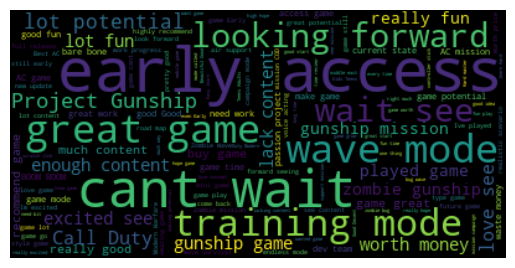

In [85]:
# Creating wordcloud to see most used words
from wordcloud import WordCloud

def plot_wordcloud(series, output_filename='wordcloud'):
    wordcloud = WordCloud().generate(" ".join(series.astype(str)))
    wordcloud.to_file(output_filename + ".png")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

plot_wordcloud(df['ReviewText_Cleaned'])

Observation: As we can see, words like "cant wait", "early access", "great game", "wave mode", "training mode", "looking forward", etc. are some of the most commonly used words in the reviews